# Opcode Frequency Extraction

## Setup

In [ ]:
import os
import pandas as pd
from pathlib import Path
import json

from collections import Counter
import matplotlib.pyplot as plt

In [7]:
PATH = Path.cwd().parents[1]
DATA_PATH = os.path.join(PATH, 'data')
NAME = 'crpwarner'
IN_PATH = os.path.join(DATA_PATH, f'external/{NAME}/groundtruth/hex')
OUT_PATH = os.path.join(DATA_PATH, f'interim/{NAME}')
PRO_PATH = os.path.join(DATA_PATH, 'processed/byte_freq')
df = pd.read_csv(os.path.join(OUT_PATH, 'dataset-modified.csv')).set_index('address')

## Load Bytecode

In [8]:
def load_bytecode(file_path):
    with open(file_path, 'r') as f:
        return f.read().strip()


## Compute Frequency per Contract

In [9]:
def byte_freq_from_file(hex_file):
    bytecode = load_bytecode(hex_file)
    if bytecode.startswith("0x"):
        bytecode = bytecode[2:]

    byte_list = [bytecode[i:i+2] for i in range(0, len(bytecode), 2)]
    return dict(Counter(byte_list))


## Build Dataset

In [10]:
hex_dir = Path(IN_PATH)
all_files = list(hex_dir.glob('*.hex'))

records = []
for file in all_files:
    freq = byte_freq_from_file(file)
    freq['address'] = file.stem.lower()
    records.append(freq)

feature_df = pd.DataFrame(records).fillna(0).set_index('address')

## Visualize or Export

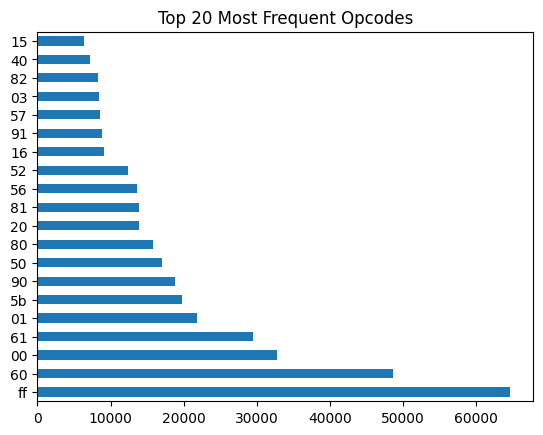

In [11]:
feature_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title("Top 20 Most Frequent Opcodes")
plt.show()

In [12]:
feature_df.to_csv(os.path.join(OUT_PATH, 'byte_freq.csv'))

## Export Labels & Feature Columns

In [13]:
labels = list(df.columns)
features = list(feature_df.columns)
with open(os.path.join(PRO_PATH, 'labels.json'), "w") as f:
    json.dump(labels, f, indent=2)

with open(os.path.join(PRO_PATH, 'features.json'), "w") as f:
    json.dump(features, f, indent=2)

## Merge with Labels Dataframe

In [14]:
df = df.merge(feature_df, left_index=True, right_index=True)
df.select_dtypes(float).fillna(0).astype(int)
df.head()

,mint,leak,limit,60,80,40,52,04,36,10,...,f6,3f,d4,e7,be,f0,e4,7e,27,9e
address,,,,,,,,,,,,,,,,,,,,,
0x93023f1d3525e273f291b6f76d2f5027a39bf302,1,0,1,410,84,55.0,134.0,73.0,15,11.0,...,0.0,8.0,0.0,1.0,0.0,2.0,2.0,0.0,2.0,1.0
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,0,0,1,668,123,79.0,188.0,85.0,25,22.0,...,4.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0,1.0,0.0
0x94b7d24552933f50a5a5705c446528806dcea381,0,0,0,17,6,1.0,3.0,0.0,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0xe0b9d4146aad6936cbfcbe4dae47e34aab96b093,0,0,0,505,163,100.0,132.0,48.0,12,17.0,...,2.0,13.0,2.0,4.0,4.0,2.0,4.0,3.0,1.0,1.0
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,1,0,1,735,213,122.0,159.0,81.0,19,54.0,...,3.0,0.0,18.0,2.0,11.0,3.0,2.0,0.0,19.0,4.0


In [15]:
df.to_csv(os.path.join(PRO_PATH, 'dataset.csv'))